# NIRCam F444W Coronagraphic Observations of Vega 
---
Here we create the basics for a MIRI simulation to observe the Fomalhaut system with the FQPM 1550. This includes simulating the Fomalhaut stellar source behind the center of the phase mask, some fake off-axis companions, and a debris disk model that crosses the mask's quadrant boundaries.

From JWST PID 1193, the pointing file provides some the relevant information. Here's a truncated version of the pointing file for the first roll position. In this example, we skip the target acquisition observations and only simulate the science exposure image.
```
* Fomalhaut-1550C-Rot1 (Obs 6)
** Visit 6:1
Aperture Name     Target        RA        Dec         V2       V3      IdlX    IdlY   Level    Type 
MIRIM_TABLOCK     1 VEGA      +279.23474 +38.78369  -407.464 -387.100  +0.000  +0.000 TARGET   T_ACQ 
MIRIM_TA1550_UR   1 VEGA      +279.23474 +38.78369  -395.471 -365.842  +0.000  +0.000 TARGET   T_ACQ 
MIRIM_TA1550_CUR  1 VEGA      +279.23474 +38.78369  -391.430 -370.519  +0.122  +0.134 TARGET   T_ACQ 
MIRIM_MASK1550    1 VEGA      +279.23474 +38.78369  -389.892 -372.181  +0.000  +0.000 TARGET   SCIENCE 
```

Final outputs will be detector-sampled slope images (counts/sec).

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import webbpsf_ext, pysiaf
from astropy.io import fits

In [3]:
from webbpsf_ext import image_manip, setup_logging, spectra, coords

# NIRCam Observation with MASK430R+F444W

## 1. Create PSF structure

In [5]:
# Mask information
filt = 'F182M'
mask = None #'MASK430R'
pupil = None #'CIRCLYOT'

# Initiate instrument class with selected filters, pupil mask, and image mask
inst = webbpsf_ext.NIRCam_ext(filter=filt, pupil_mask=pupil, image_mask=mask)

[   webbpsf:INFO] NIRCam aperture name updated to NRCA1_FULL


In [6]:
# Set desired PSF size and oversampling
inst.fov_pix = 65
inst.oversample = 2
inst.quick = True

In [21]:
w1, w2 = inst.wave_fit
# inst.ndeg = 8
npsf = int(np.ceil(30 * (w2-w1)))
# npsf = inst.npsf
waves = np.linspace(w1, w2, npsf)

In [22]:
from webbpsf_ext.webbpsf_ext_core import _wrap_coeff_for_mp
from webbpsf_ext.maths import jl_poly, jl_poly_fit

In [23]:
setup_logging('WARN', verbose=False)
worker_arguments = [(inst, wlen) for wlen in waves]
hdu_arr = []
for wa in tqdm(worker_arguments, desc='Single PSFs', leave=False):
    hdu = _wrap_coeff_for_mp(wa)
    hdu_arr.append(hdu)
    
# Extract image data from HDU array
images = []
for hdu in hdu_arr:
    images.append(hdu.data)

# Turn results into an numpy array (npsf,ny,nx)
images = np.array(images)

Single PSFs:   0%|          | 0/11 [00:00<?, ?it/s]

In [25]:
int(np.ceil(20 * (w2-w1)))

8

In [20]:
int(np.ceil(30 * (w2-w1)))

11

In [18]:
waves

array([1.6645    , 1.71664286, 1.76878571, 1.82092857, 1.87307143,
       1.92521429, 1.97735714, 2.0295    ])

55 25


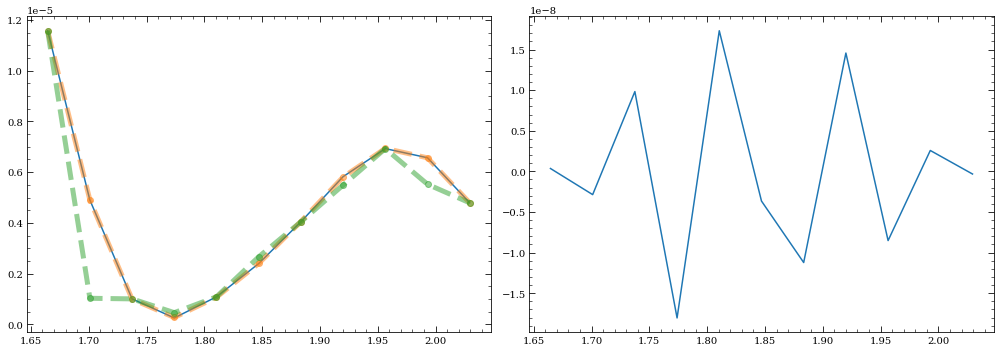

In [27]:
iy, ix = np.random.randint(4,120, 2)
# iy, ix = (58, 18)
iy, ix = 55, 25
#iy, ix = (49,5)
vals = images[:,iy,ix]
print(iy,ix)

# Simultaneous polynomial fits to all pixels using linear least squares
ndeg = 8
cf0 = jl_poly_fit(waves, vals, deg=ndeg, use_legendre=True, lxmap=[w1,w2])
cf1 = jl_poly_fit(waves[0::2], vals[0::2], deg=ndeg, use_legendre=True, lxmap=[w1,w2])
# cf2 = jl_poly_fit(waves[0::4], vals[0::4], deg=ndeg, use_legendre=True, lxmap=[w1,w2])

fig, axes = plt.subplots(1,2, figsize=(14,5))

axes[0].plot(waves, vals)
for cf in [cf0,cf1]:
    vfit = jl_poly(waves, cf, use_legendre=True, lxmap=[w1,w2])
    axes[0].plot(waves, vfit, ls='--', lw=5, marker='o', alpha=0.5)

vfit = jl_poly(waves, cf0, use_legendre=True, lxmap=[w1,w2])
diff = vals - vfit
axes[1].plot(waves, diff)

fig.tight_layout()

In [6]:
# Calculate PSF coefficients
inst.gen_psf_coeff()

[webbpsf_ext:INFO] Generating and saving PSF coefficient


Single PSFs:   0%|          | 0/29 [00:00<?, ?it/s]

[webbpsf_ext:INFO] Took 44.40 seconds to generate WebbPSF images
[webbpsf_ext:INFO] Saving to /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_F444W_CIRCLYOT_MASK430R_pix257_os2_jsig0_r0.00_th+0.0_RevWslice0_siwfe_distort_legendre.fits


In [7]:
# Calculate position-dependent PSFs due to FQPM
# Equivalent to generating a giant library to interpolate over
inst.gen_wfemask_coeff(force=True)

[webbpsf_ext:WARNING] Generating mask position-dependent coefficients. This may take some time...


Mask Offsets:   0%|          | 0/81 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

SGD:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/8 [00:00<?, ?it/s]

[webbpsf_ext:INFO] Saving to /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_F430M_CIRCLYOT_MASK430R_pix129_os2_jsig0_r0.00_th+0.0_RevWslice0_siwfe_distort_legendre_wfemask.npz


## 1.1 Observation setup

__Configuring observation settings__

Observations consist of nested visit, mosaic tiles, exposures, and dithers. In this section, we configure a pointing class that houses information for a single observation defined in the APT .pointing file. The primary information includes a pointing reference SIAF aperturne name, RA and Dec of the ref aperture, Base X/Y offset relative to the ref aperture position, and Dith X/Y offsets. From this information, along with the V2/V3 position angle, we can determine the orientation and location of objects on the detector focal plane.

**Note**: The reference aperture is not necessarily the same as the observed aperture. For instance, you may observe simultaneously with four of NIRCam's SWA detectors, so the reference aperture would be the entire SWA channel, while the observed apertures are A1, A2, A3, and A4.

In [61]:
# Import class to setup pointing info
from webbpsf_ext.coords import jwst_point

In [62]:
# Observed and reference apertures
ap_obs = 'NRCA5_MASK430R'
ap_ref = 'NRCA5_MASK430R'
    
# Define the RA/Dec of reference aperture and telescope position angle
# Position angle is angle of V3 axis rotated towards East
ra_ref, dec_ref = (+279.23474,  +38.78369)
pos_ang = 0

# Set any baseline pointing offsets (e.g., specified in APT's Special Requirements)
base_offset=(0,0)
# Define a list of nominal dither offsets
dith_offsets = [(0,0)]

# Telescope pointing information
tel_point = jwst_point(ap_obs, ap_ref, ra_ref, dec_ref, pos_ang=pos_ang,
                       base_offset=base_offset, dith_offsets=dith_offsets,
                       base_std=0, dith_std=0)

[webbpsf_ext:INFO] Generating random pointing offsets...
[webbpsf_ext:INFO] Pointing uncertainty: 0.0 mas
[webbpsf_ext:INFO]   Pos 0 dither uncertainty: 0.0 mas


In [63]:
print(f"Reference aperture: {tel_point.siaf_ap_ref.AperName}")
print(f"  Nominal RA, Dec = ({tel_point.ra_ref:.6f}, {tel_point.dec_ref:.6f})")
print(f"Observed aperture: {tel_point.siaf_ap_obs.AperName}")
print(f"  Nominal RA, Dec = ({tel_point.ra_obs:.6f}, {tel_point.dec_obs:.6f})")

print(f"Relative offsets in 'idl' for each dither position (incl. pointing errors)")
for i, offset in enumerate(tel_point.position_offsets_act):
    print(f"  Position {i}: ({offset[0]:.4f}, {offset[1]:.4f}) arcsec")

Reference aperture: NRCA5_MASK430R
  Nominal RA, Dec = (279.234740, 38.783690)
Observed aperture: NRCA5_MASK430R
  Nominal RA, Dec = (279.234740, 38.783690)
Relative offsets in 'idl' for each dither position (incl. pointing errors)
  Position 0: (0.0000, 0.0000) arcsec


## 1.2 Add central source

Here we define the stellar atmosphere parameters for Fomalhaut, including spectral type, optional values for (Teff, log_g, metallicity), normalization flux and bandpass, as well as RA and Dec.

In [64]:
from webbpsf_ext import miri_filter, nircam_filter, bp_2mass
from webbpsf_ext.image_manip import pad_or_cut_to_size

def make_spec(name=None, sptype=None, flux=None, flux_units=None, bp_ref=None, **kwargs):
    """
    Create pysynphot stellar spectrum from input dictionary properties.
    """

    from webbpsf_ext import stellar_spectrum
    
    # Renormalization arguments
    renorm_args = (flux, flux_units, bp_ref)
    
    # Create spectrum
    sp = stellar_spectrum(sptype, *renorm_args, **kwargs)
    if name is not None:
        sp.name = name
    
    return sp

In [65]:
# Information necessary to create pysynphot spectrum of star
obj_params = {
    'name': 'Vega', 
    'sptype': 'A0V', 
    'Teff': 9602, 'log_g': 4.1, 'metallicity': -0.5, 
    'dist': 7.7,
    'flux': 16.09, 'flux_units': 'Jy', 'bp_ref': miri_filter('F1550C'),
    'RA_obj'  : +279.23474,  # RA (decimal deg) of source
    'Dec_obj' :  +38.78369,  # Dec (decimal deg) of source
}

In [66]:
# Create stellar spectrum and add to dictionary
sp_star = make_spec(**obj_params)
obj_params['sp'] = sp_star

In [67]:
# Get `sci` coord positions
coord_obj = (obj_params['RA_obj'], obj_params['Dec_obj'])
xsci, ysci = tel_point.radec_to_frame(coord_obj, frame_out='sci')

# Get sci position shifts from center in units of detector pixels
siaf_ap = tel_point.siaf_ap_obs
xsci_cen, ysci_cen = siaf_ap.reference_point('sci')
xsci_off, ysci_off = (xsci-xsci_cen, ysci-ysci_cen)

# and now oversampled pixel shifts
osamp = inst.oversample
xsci_off_over = xsci_off * osamp
ysci_off_over = ysci_off * osamp

print("Image shifts (oversampled pixels):", xsci_off_over, ysci_off_over)

Image shifts (oversampled pixels): 9.72022462519817e-12 2.7114310796605423e-11


In [68]:
# Create PSF
# PSFs already includes geometric distortions based on SIAF info
sp = obj_params['sp']
xtel, ytel = siaf_ap.convert(xsci, ysci, 'sci', 'tel')
hdul = inst.calc_psf_from_coeff(sp=sp, coord_vals=(xtel,ytel), coord_frame='tel')

# Expand PSF to full frame and offset to proper position
ny_pix, nx_pix = (siaf_ap.YSciSize, siaf_ap.XSciSize)
ny_pix_over, nx_pix_over = np.array([ny_pix, nx_pix]) * osamp
shape_new = (ny_pix*osamp, nx_pix*osamp)
delyx = (ysci_off_over, xsci_off_over)
image_full = pad_or_cut_to_size(hdul[0].data, shape_new, offset_vals=delyx)

# Make new HDUList of target (just central source so far)
hdul_full = fits.HDUList(fits.PrimaryHDU(data=image_full, header=hdul[0].header))

[webbpsf_ext:INFO] Generating mask-dependent modifications...


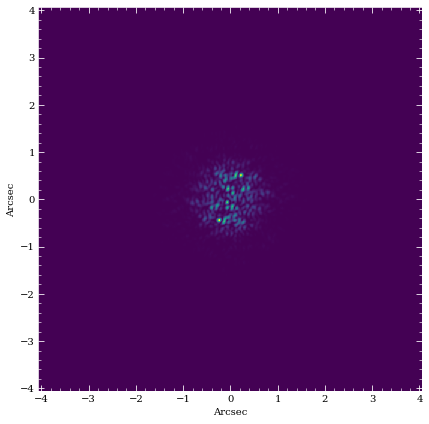

In [69]:
fig, ax = plt.subplots(1,1)

extent = 0.5 * np.array([-1,1,-1,1]) * inst.fov_pix * inst.pixelscale
ax.imshow(hdul_full[0].data, extent=extent)

ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

ax.tick_params(axis='both', color='white', which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color('white')
ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

fig.tight_layout()

## 1.3 Convolve extended disk image

Properly including extended objects is a little more complicated than for point sources. First, we need properly format the input model to a pixel binning and flux units appropriate for the simulations (ie., pixels should be equal to oversampled PSFs with flux units of counts/sec). Then, the image needs to be rotated relative to the 'idl' coordinate plane and subsequently shifted for any pointing offsets. Once in the appropriate 'idl' system 


### 1.3.1 PSF Grid

In [70]:
# Create grid locations for array of PSFs to generate
field_rot = 0 if inst._rotation is None else inst._rotation

rvals = 10**(np.linspace(-2,1,7))
thvals = np.linspace(0, 360, 7, endpoint=False)

rvals_all = [0]
thvals_all = [0]
for r in rvals:
    for th in thvals:
        rvals_all.append(r)
        thvals_all.append(th)
rvals_all = np.array(rvals_all)
thvals_all = np.array(thvals_all)

xgrid_off, ygrid_off = coords.rtheta_to_xy(rvals_all, thvals_all)

# xyoff_half = 10**(np.linspace(-2,1,5))
# xoff = yoff = np.concatenate([-1*xyoff_half[::-1],[0],xyoff_half])

# # Mask Offset grid positions in arcsec
# xgrid_off, ygrid_off = np.meshgrid(xoff, yoff)
# xgrid_off, ygrid_off = xgrid_off.flatten(), ygrid_off.flatten()

# Science positions in detector pixels
xoff_sci_asec, yoff_sci_asec = coords.xy_rot(-1*xgrid_off, -1*ygrid_off, -1*field_rot)
xsci = xoff_sci_asec / siaf_ap.XSciScale + siaf_ap.XSciRef
ysci = yoff_sci_asec / siaf_ap.YSciScale + siaf_ap.YSciRef

xtel, ytel = siaf_ap.convert(xsci, ysci, 'sci', 'tel')

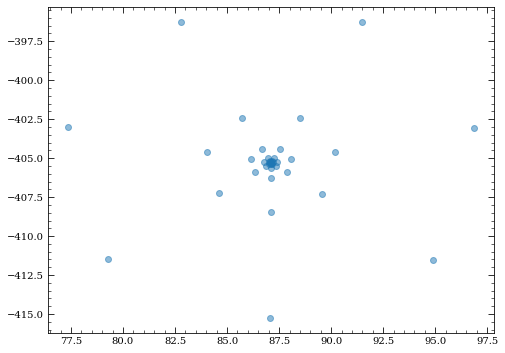

In [71]:
plt.plot(xtel, ytel, marker='o', ls='none', alpha=0.5)

In [72]:
%%time

# Now, create all PSFs, one for each (xsci, ysci) location
# Only need to do this once. Can be used for multiple dither positions.
hdul_psfs = inst.calc_psf_from_coeff(coord_vals=(xtel, ytel), coord_frame='tel', return_oversample=True)

[webbpsf_ext:INFO] Generating mask-dependent modifications...


PSFs:   0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 14.4 s, sys: 750 ms, total: 15.1 s
Wall time: 4.46 s


### 1.3.2 Disk Model Image

In [73]:
# Disk model information
disk_params = {
    'file': "Vega/Vega_F444Wsccomb.fits",
    'pixscale': inst.pixelscale,
    'wavelength': 4.4,
    'units': 'Jy/pixel',
    'dist' : 7.7,
    'cen_star' : False,
}

# Open model and rebin to PSF sampling
# Scale to instrument wavelength assuming grey scattering function
# Converts to phot/sec/lambda
# Crop to twice the FoV
ny_over = int(2*siaf_ap.YSciSize*inst.oversample)
nx_over = int(2*siaf_ap.XSciSize*inst.oversample)
shape_out = (ny_over, nx_over)
hdul_disk_model = image_manip.make_disk_image(inst, disk_params, sp_star=obj_params['sp'], 
                                              shape_out=shape_out)

# Rotation necessary to go from sky coordinates to 'idl' frame
rotate_to_idl = -1*(tel_point.siaf_ap_obs.V3IdlYAngle + tel_point.pos_ang)

### 1.3.3 Dither Position

In [74]:
# Select the first dither location offset
delx, dely = tel_point.position_offsets_act[0]
hdul_out = image_manip.rotate_shift_image(hdul_disk_model, PA_offset=rotate_to_idl,
                                          delx_asec=delx, dely_asec=dely)

sci_cen = (siaf_ap.XSciRef, siaf_ap.YSciRef)

# Distort image on 'sci' coordinate grid
im_sci, xsci_im, ysci_im = image_manip.distort_image(hdul_out, ext=0, to_frame='sci', return_coords=True, 
                                                     aper=siaf_ap, sci_cen=sci_cen)

# Distort image onto 'tel' (V2, V3) coordinate grid for plot illustration
im_tel, v2_im, v3_im = image_manip.distort_image(hdul_out, ext=0, to_frame='tel', return_coords=True, 
                                                 aper=siaf_ap, sci_cen=sci_cen)

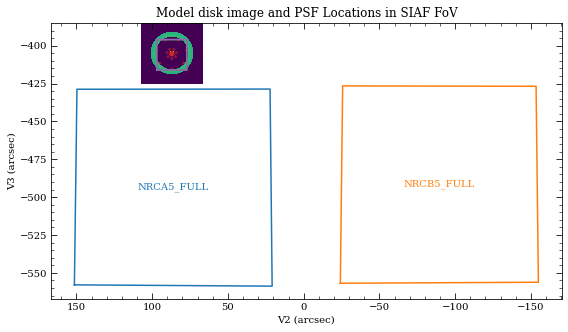

In [75]:
# Plot locations for PSFs that we will generate
fig, ax = plt.subplots(1,1)

# Show image in V2/V3 plane
extent = [v2_im.min(), v2_im.max(), v3_im.min(), v3_im.max()]
ax.imshow(im_tel**0.1, extent=extent)

# Add on SIAF aperture boundaries
tel_point.plot_inst_apertures(ax=ax, clear=False, label=True)
tel_point.plot_ref_aperture(ax=ax)
tel_point.plot_obs_aperture(ax=ax, color='C4')

# Add PSF location points
v2, v3 = siaf_ap.convert(xsci, ysci, 'sci', 'tel')
ax.scatter(v2, v3, marker='.', alpha=0.5, color='C3', edgecolors='none', linewidths=0)

ax.set_title('Model disk image and PSF Locations in SIAF FoV')

fig.tight_layout()

This particular disk image is oversized, so we will need to crop the image after convolving PSFs. We may want to consider trimming some of this image prior to convolution, depending on how some of the FoV is blocked before reaching the coronagraphic optics.

In [76]:
# If the image is too large, then this process will eat up much of your computer's RAM
# So, crop image to more reasonable size (20% oversized)
osamp = inst.oversample
xysize = int(1.2 * np.max([siaf_ap.XSciSize,siaf_ap.YSciSize]) * osamp)
xy_add = osamp - np.mod(xysize, osamp)
xysize += xy_add

im_sci = pad_or_cut_to_size(im_sci, xysize)
hdul_disk_model_sci = fits.HDUList(fits.PrimaryHDU(data=im_sci, header=hdul_out[0].header))

In [77]:
# Convolve image
im_conv = image_manip.convolve_image(hdul_disk_model_sci, hdul_psfs, aper=siaf_ap)

  0%|          | 0/50 [00:00<?, ?it/s]

Closing multiprocess pool.


In [34]:
(np.array(siaf_ap.convert(0,-1.2,'idl','sci')) - siaf_ap.reference_point('sci'))*inst.pixelscale

array([ 1.64463236e-05, -1.20209902e+00])

In [28]:
hdul = inst.calc_psf_from_coeff(coord_vals=[[0,1.2],[-1.2,0]], coord_frame='idl')
hdul1 = inst.calc_psf_from_coeff(coord_vals=[0,-1.2], coord_frame='idl')
hdul2 = inst.calc_psf_from_coeff(coord_vals=[1.2,0], coord_frame='idl')

[webbpsf_ext:INFO] Generating mask-dependent modifications...
[ 6.80423645e-05 -1.19983407e+00] [ 1.20021218e+00 -6.28545547e-04]


PSFs:   0%|          | 0/2 [00:00<?, ?it/s]

[webbpsf_ext:INFO] Generating mask-dependent modifications...
6.804236449968194e-05 1.2002121839196989
[webbpsf_ext:INFO] Generating mask-dependent modifications...
-1.1998340745500315 -0.0006285455473361113


In [29]:
from scipy.interpolate import griddata, RegularGridInterpolator
def field_coeff_func2(xgrid, ygrid, cf_fields, x_new, y_new):
    """Interpolation function for PSF coefficient residuals

    Uses `RegularGridInterpolator` to quickly determine new coefficient
    residulas at specified points.

    Parameters
    ----------
    v2grid : ndarray
        V2 values corresponding to `cf_fields`.
    v3grid : ndarray
        V3 values corresponding to `cf_fields`.
    cf_fields : ndarray
        Coefficient residuals at different field points
        Shape is (nV3, nV2, ncoeff, ypix, xpix)
    v2_new : ndarray
        New V2 point(s) to interpolate on. Same units as v2grid.
    v3_new : ndarray
        New V3 point(s) to interpolate on. Same units as v3grid.
    """

    func = RegularGridInterpolator((ygrid, xgrid), cf_fields, method='linear', 
                                   bounds_error=False, fill_value=None)

    pts = np.array([y_new,x_new]).transpose()
    
    # If only 1 point, remove first axes
    res = func(pts)
    res = res.squeeze() if res.shape[0]==1 else res
    
    return res



In [54]:
apname = inst._psf_coeff_mod['si_mask_apname']
xgrid  = inst._psf_coeff_mod['si_mask_xgrid']
ygrid  = inst._psf_coeff_mod['si_mask_ygrid']
cf_fit = inst._psf_coeff_mod['si_mask']

x_new, y_new = (0, 1.2)
psf_coeff_mod1 = field_coeff_func2(xgrid, ygrid, cf_fit, x_new, y_new)

psf_coeff1 = inst.psf_coeff + psf_coeff_mod1
psf_coeff_hdr = inst.psf_coeff_header

from webbpsf_ext.psfs import gen_image_from_coeff
res1 = gen_image_from_coeff(inst, psf_coeff1, psf_coeff_hdr, return_oversample=True)

x_new, y_new = (-1.2, 0)
psf_coeff_mod2 = field_coeff_func2(xgrid, ygrid, cf_fit, x_new, y_new)

psf_coeff2 = inst.psf_coeff + psf_coeff_mod2
psf_coeff_hdr = inst.psf_coeff_header

from webbpsf_ext.psfs import gen_image_from_coeff
res2 = gen_image_from_coeff(inst, psf_coeff2, psf_coeff_hdr, return_oversample=True)

0.0008281046908363936 0.0010153636284455235 0.001016985295783932


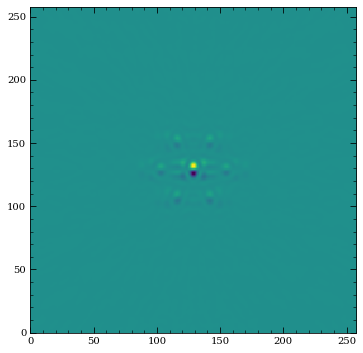

In [59]:
diff = psf_coeff_mod2[0] - psf_coeff_mod1[0]
plt.imshow(diff)

print(diff.max(), psf_coeff_mod1[0].max(), psf_coeff_mod2[0].max())

In [60]:
xy_inner = np.array([0.015, 0.02, 0.05, 0.1])
xy_mid = np.array([0.6, 1.2, 2, 2.5])
xy_outer = np.array([5.0, 8.0])

xy_pos = np.concatenate((xy_inner, xy_mid, xy_outer))
xy_neg = -1 * xy_pos[::-1]

xy_offsets = np.concatenate((xy_neg, [0], xy_pos))

In [40]:
webbpsf_ext.setup_logging('warn')

siaf_ap_inst = inst.siaf[inst.aperturename]

inst.options['coron_shift_x'] = 0
inst.options['coron_shift_y'] = 1.2
inst.detector_position = siaf_ap_inst.convert(0, -1.2, 'idl', 'sci')

psf1 = inst.calc_psf()

inst.options['coron_shift_x'] = -1.2
inst.options['coron_shift_y'] = 0
inst.detector_position = siaf_ap_inst.convert(1.2, 0, 'idl', 'sci')

psf2 = inst.calc_psf()

webbpsf_ext.setup_logging('info')

webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
webbpsf_ext log messages of level INFO and above will be shown.
webbpsf_ext log outputs will be directed to the screen.


In [44]:
psf1[0].shape

(258, 258)

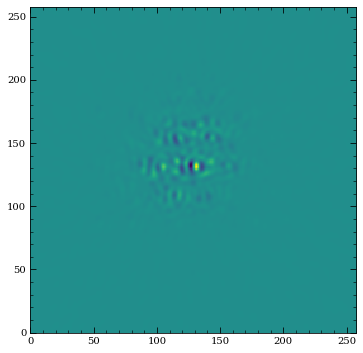

In [46]:
plt.imshow(psf1[2].data - psf2[2].data)

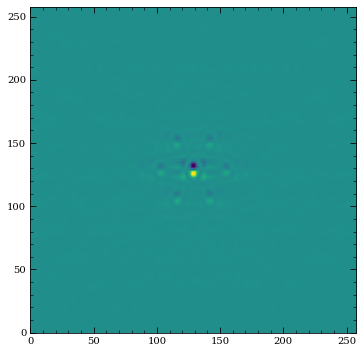

In [39]:
plt.imshow(hdul[0].data - hdul[1].data)

In [25]:
print(inst._psf_coeff_mod['si_mask_xgrid'])
print(inst._psf_coeff_mod['si_mask_ygrid'])

[-8.    -5.    -2.5   -2.    -1.2   -0.6   -0.1   -0.05  -0.02  -0.015
  0.     0.015  0.02   0.05   0.1    0.6    1.2    2.     2.5    5.
  8.   ]
[-8.    -5.    -2.5   -2.    -1.2   -0.6   -0.1   -0.05  -0.02  -0.015
  0.     0.015  0.02   0.05   0.1    0.6    1.2    2.     2.5    5.
  8.   ]


In [31]:
print(xoff_sci_asec[29], yoff_sci_asec[29])
print(xoff_sci_asec[31], yoff_sci_asec[31])

0.0 -1.0
0.9749279121818236 0.22252093395631423


In [26]:
for i in range(len(hdul_psfs)):
    hdu = hdul_psfs[i]
    data = hdu.data
    print(i, data.sum())

0 0.0010398920349311155
1 0.0010407381283255312
2 0.0010413961679559957
3 0.0010413203470141582
4 0.0010413730186815803
5 0.0010412061767173764
6 0.0010409107125466475
7 0.0010410550826118802
8 0.0010489682431460688
9 0.0010485693758985333
10 0.0010503770129828254
11 0.0010492539485348392
12 0.001048893532613853
13 0.0010499783275186847
14 0.0010478376432817885
15 0.001163632693302384
16 0.0011904673740943074
17 0.0011623459196221499
18 0.0011679861993424405
19 0.0011717153337127883
20 0.0011662991733154473
21 0.001188161259423465
22 0.018591620001240122
23 0.02268154306251608
24 0.018413983172651388
25 0.020331600188052384
26 0.02035076740544235
27 0.018431383359924378
28 0.02269601257057709
29 0.1249723796572471
30 0.12601376647008355
31 0.1279792491458024
32 0.12788600328762842
33 0.1278980091323295
34 0.128012023348338
35 0.12603647018037092
36 0.1804986454076035
37 0.18113743462345114
38 0.18082160014712595
39 0.1811394898104704
40 0.1811403758431533
41 0.18082254399133307
42 0.18

In [ ]:
inst.calc_psf

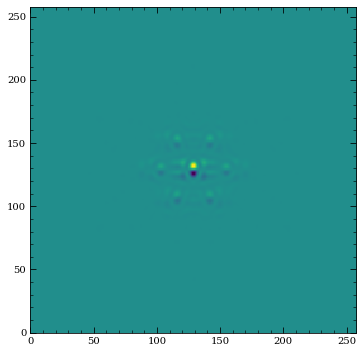

In [28]:
plt.imshow(hdul_psfs[31].data - hdul_psfs[29].data)

In [49]:
print(xgrid_off[29:36], ygrid_off[29:36])
print((xsci[29], ysci[29]), (xsci[31], ysci[31]))

[ 0.         -0.78183148 -0.97492791 -0.43388374  0.43388374  0.97492791
  0.78183148] [ 1.          0.6234898  -0.22252093 -0.90096887 -0.90096887 -0.22252093
  0.6234898 ]
(160.5, 156.60091972999547) (176.20798061768707, 176.0378781907278)


In [141]:
from webbpsf_ext.coords import xy_rot, xy_to_rtheta

detector_position_orig = np.array([973.5, 1673.5])
siaf_ap_orig = inst.siaf[inst.aperturename]

v2_1, v3_1 = hdul_psfs[29].header['XVAL'], hdul_psfs[29].header['YVAL']
v2_2, v3_2 = hdul_psfs[31].header['XVAL'], hdul_psfs[31].header['YVAL']

# Detector position
xysci0 = np.array(siaf_ap_orig.reference_point('sci'))
xysci1 = np.array(siaf_ap_orig.convert(v2_1, v3_1, 'tel', 'sci'))
xysci2 = np.array(siaf_ap_orig.convert(v2_2, v3_2, 'tel', 'sci'))

# Offset in arcsec
xyoff1_asec = (xysci1 - xysci0) * inst.pixelscale
xyoff2_asec = (xysci2 - xysci0) * inst.pixelscale

# Mask shifting
field_rot = 0 if inst._rotation is None else inst._rotation
xyoff1_mask = np.array(xy_rot(-1*xyoff1_asec[0], -1*xyoff1_asec[1], field_rot))
xyoff2_mask = np.array(xy_rot(-1*xyoff2_asec[0], -1*xyoff2_asec[1], field_rot))

In [163]:
webbpsf_ext.setup_logging('warn')

inst.options['coron_shift_x'] = xyoff1_mask[0]
inst.options['coron_shift_y'] = xyoff1_mask[1]
inst.detector_position = xysci1

inst.include_si_wfe = True
psf1 = inst.calc_psf(fov_pixels=256, oversample=2, add_distortion=True)

inst.options['coron_shift_x'] = xyoff2_mask[0]
inst.options['coron_shift_y'] = xyoff2_mask[1]
inst.detector_position = xysci2

psf2 = inst.calc_psf(fov_pixels=256, oversample=2, add_distortion=True, monochromatic=4.5e-6)

webbpsf_ext.setup_logging('info')

webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
webbpsf_ext log messages of level INFO and above will be shown.
webbpsf_ext log outputs will be directed to the screen.


In [154]:
inst.include_si_wfe

True

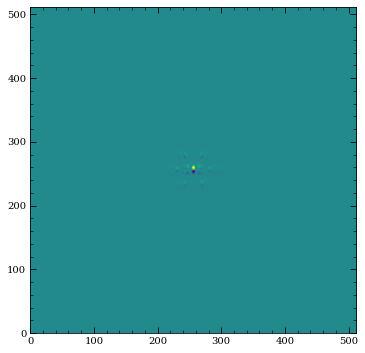

In [165]:
plt.imshow(psf1[0].data - hdul_psfs[29].data)

In [133]:
xyoff1, xyoff2

(array([ 973.4983896 , 1657.59919523]), array([ 989.20622674, 1677.0365447 ]))

In [99]:
inst2 = webbpsf_ext.MIRI_ext(filter='F1550C', pupil_mask='MASKFQPM', image_mask='FQPM1550')
inst2.options['coron_shift_y'] = 0 #5

x_new, y_new = xy_rot(-1*0, -1*5, -1*inst2._rotation)
rnew, thnew = xy_to_rtheta(x_new, y_new)

inst2.options['source_offset_r'] = 5        
inst2.options['source_offset_theta'] = thnew

[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_FULL
[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_CORON1550


In [104]:
np.array(xy_rot(-1*x_new, -1*y_new, inst2._rotation))

array([1.78268834e-15, 5.00000000e+00])

In [ ]:
np.array(xy_rot(-1*xoff[i], -1*yoff[i], -field_rot))

In [102]:
x_new, y_new

(-0.3879193563326856, -4.984929144228876)

In [84]:
psf = inst2.calc_psf(monochromatic=15.5e-6, fov_pixels=129, oversample=2, add_distortion=False)

[     poppy:INFO] Monochromatic calculation requested.
[     poppy:INFO] PSF calc using fov_pixels = 129, oversample = 2, number of wavelengths = 1
[   webbpsf:INFO] Creating optical system model:
[     poppy:INFO] Initialized OpticalSystem: JWST+MIRI
[     poppy:INFO] JWST Entrance Pupil: Loaded amplitude transmission from /Users/Jarron/NIRCam/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz
[     poppy:INFO] JWST Entrance Pupil: Loaded OPD from  /Users/Jarron/NIRCam/webbpsf-data/MIRI/OPD/OPD_RevW_ote_for_MIRI_predicted.fits.gz, plane 0
[     poppy:INFO] Added pupil plane: JWST Entrance Pupil
[     poppy:INFO] Added coordinate inversion plane: OTE exit pupil
[     poppy:INFO] Added rotation plane: Rotation by -4.45 degrees
[     poppy:INFO] Added pupil plane: FQPM FFT aligner
[     poppy:INFO] Added image plane: MIRI FQPM 1550
[     poppy:INFO] Added pupil plane: FQPM FFT aligner
[   webbpsf:INFO] Setting Lyot pupil shift to (-0.0455639016, -0.0178293528)
[     poppy:INFO] MASKFQPM: Load

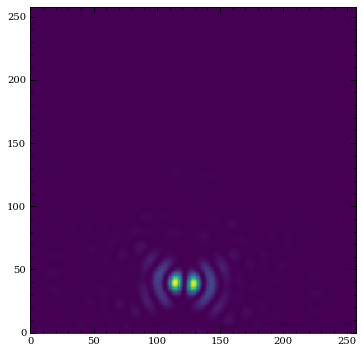

In [101]:
plt.imshow(psf2[0].data)

In [58]:
siaf_ap_miri = inst2.siaf[inst2.aperturename]

In [74]:
siaf_ap.convert(0,0,'idl','sci')

(160.4986426527082, 172.4986670173655)

In [75]:
siaf_ap.convert(0,100,'idl','sci')

(164.89313129875302, 1738.0553752144065)

In [52]:
siaf_ap.AperName

'NRCA5_MASK430R'

In [55]:
siaf_ap2.reference_point('sci')

(973.4986426527082, 1673.4986670173655)

In [54]:
siaf_ap2 = inst.siaf[inst.aperturename]
siaf_ap2.convert(87.0994843109966, -406.2905729490961, 'tel', 'sci')

(973.4983895976736, 1657.5991952299644)

In [ ]:
XVAL    =     87.0994843109966 / [arcsec] Input X coordinate                    
YVAL    =   -406.2905729490961 / [arcsec] Input Y coordinate 

In [51]:
hdul_psfs[29].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
DESCR   = 'PSF Coeffecients'   / File Description                               
NWAVES  =                   10 / Number of wavelengths used in calculation      
EXTNAME = 'OVERSAMP'           / This extension is oversampled.                 
OVERSAMP=                    2 / Oversampling factor for FFTs in computation    
DET_SAMP=                    2 / Oversampling factor for MFT to detector plane  
PIXELSCL=               0.03

In [ ]:
psf1 = inst.calc_psf()

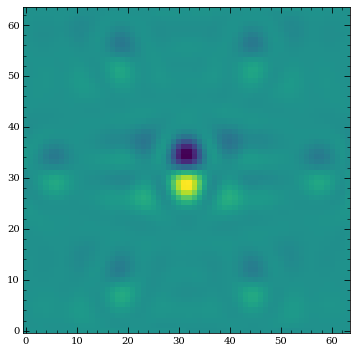

In [25]:
plt.imshow(hdul_psfs[29].data - hdul_psfs[31].data)

In [49]:
import scipy
from scipy import fftpack
from astropy.convolution import convolve, convolve_fft

psf = hdul_psfs[-1].data
im_temp = im_sci.copy()

norm = psf.sum()
psf = psf / norm
res = convolve_fft(im_temp, psf, fftn=fftpack.fftn, ifftn=fftpack.ifftn, allow_huge=True)
res *= norm

im_conv = res

In [78]:
# Add cropped image to final oversampled image
im_conv = pad_or_cut_to_size(im_conv, hdul_full[0].data.shape)
hdul_full[0].data = im_conv

In [79]:
def quick_ref_psf(idl_coord, inst, tel_point, out_shape, sp=None):
    """
    Create a quick reference PSF for subtraction of the science target.
    """
    
    # Observed SIAF aperture
    siaf_ap = tel_point.siaf_ap_obs
    
    # Location of observation
    xidl, yidl = idl_coord
    
    # Get offset in SCI pixels
    xsci_off, ysci_off = np.array(siaf_ap.convert(xidl, yidl, 'idl', 'sci')) - \
                         np.array(siaf_ap.reference_point('sci'))
    
    # Get oversampled pixels offests
    osamp = inst.oversample
    xsci_off_over, ysci_off_over = np.array([xsci_off, ysci_off]) * osamp
    yx_offset = (ysci_off_over, xsci_off_over)
    
    # Create PSF
    prev_log = webbpsf_ext.conf.logging_level
    setup_logging('WARN', verbose=False)
    xtel, ytel = siaf_ap.convert(xidl, yidl, 'idl', 'tel')
    hdul_psf_ref = inst.calc_psf_from_coeff(sp=sp, coord_vals=(xtel, ytel), coord_frame='tel')
    setup_logging(prev_log, verbose=False)

    im_psf = pad_or_cut_to_size(hdul_psf_ref[0].data, out_shape, offset_vals=yx_offset)

    return im_psf

In [80]:


# Subtract a reference PSF from the science data
coord_vals = tel_point.position_offsets_act[0]
im_psf = quick_ref_psf(coord_vals, inst, tel_point, hdul_full[0].data.shape, sp=sp_star)
im_ref = image_manip.frebin(im_psf, scale=1/osamp)

# Rebin science data to detector pixels
im_sci = image_manip.frebin(hdul_full[0].data, scale=1/osamp) + im_ref
imdiff = im_sci - im_ref

# De-rotate to sky orientation
imrot = image_manip.rotate_offset(imdiff, rotate_to_idl, reshape=False, cval=np.nan)

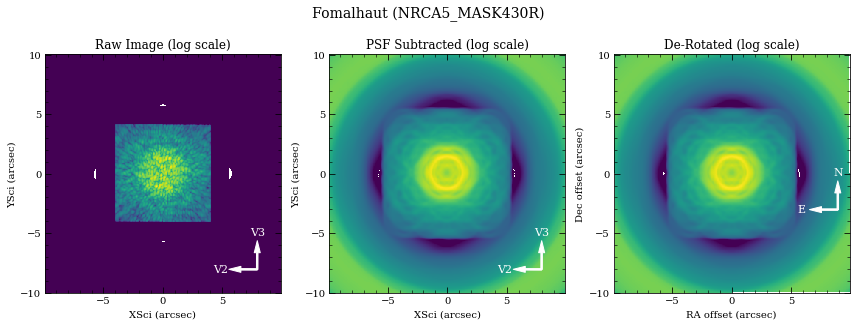

In [83]:
from matplotlib.colors import LogNorm
from webbpsf_ext.coords import plotAxes

fig, axes = plt.subplots(1,3, figsize=(12,4.5))

############################
# Plot raw image
ax = axes[0]

im = im_sci
mn = np.median(im)
std = np.std(im)
vmin = 0
vmax = mn+10*std

xsize_asec = siaf_ap.XSciSize * siaf_ap.XSciScale
ysize_asec = siaf_ap.YSciSize * siaf_ap.YSciScale
extent = [-1*xsize_asec/2, xsize_asec/2, -1*ysize_asec/2, ysize_asec/2]
norm = LogNorm(vmin=im.max()/1e5, vmax=im.max())
ax.imshow(im, extent=extent, norm=norm)

ax.set_title("Raw Image (log scale)")

ax.set_xlabel('XSci (arcsec)')
ax.set_ylabel('YSci (arcsec)')
plotAxes(ax, angle=-1*siaf_ap.V3SciYAngle)

############################
# Basic PSF subtraction
# Subtract a near-perfect reference PSF
ax = axes[1]
norm = LogNorm(vmin=imdiff.max()/1e5, vmax=imdiff.max())
ax.imshow(imdiff, extent=extent, norm=norm)

ax.set_title("PSF Subtracted (log scale)")

ax.set_xlabel('XSci (arcsec)')
ax.set_ylabel('YSci (arcsec)')
plotAxes(ax, angle=-1*siaf_ap.V3SciYAngle)

############################
# De-rotate to sky orientation

ax = axes[2]
ax.imshow(imrot, extent=extent, norm=norm)

ax.set_title("De-Rotated (log scale)")

ax.set_xlabel('RA offset (arcsec)')
ax.set_ylabel('Dec offset (arcsec)')
plotAxes(ax, position=(0.95,0.35), label1='E', label2='N')

for i, ax in enumerate(axes.flatten()):
    ax.xaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])

fig.suptitle(f"Fomalhaut ({siaf_ap.AperName})", fontsize=14)
fig.tight_layout()

In [1]:
from matplotlib.colors import LogNorm
from webbpsf_ext.coords import plotAxes

fig, axes = plt.subplots(1,3, figsize=(12,4.5))

############################
# Plot raw image
ax = axes[0]

im = im_sci
mn = np.median(im)
std = np.std(im)
vmin = 0
vmax = mn+10*std

xsize_asec = siaf_ap.XSciSize * siaf_ap.XSciScale
ysize_asec = siaf_ap.YSciSize * siaf_ap.YSciScale
extent = [-1*xsize_asec/2, xsize_asec/2, -1*ysize_asec/2, ysize_asec/2]
norm = LogNorm(vmin=im.max()/1e5, vmax=im.max())
ax.imshow(im, extent=extent, norm=norm)

ax.set_title("Raw Image (log scale)")

ax.set_xlabel('XSci (arcsec)')
ax.set_ylabel('YSci (arcsec)')
plotAxes(ax, angle=-1*siaf_ap.V3SciYAngle)

############################
# Basic PSF subtraction
# Subtract a near-perfect reference PSF
ax = axes[1]
norm = LogNorm(vmin=imdiff.max()/1e5, vmax=imdiff.max())
ax.imshow(imdiff, extent=extent, norm=norm)

ax.set_title("PSF Subtracted (log scale)")

ax.set_xlabel('XSci (arcsec)')
ax.set_ylabel('YSci (arcsec)')
plotAxes(ax, angle=-1*siaf_ap.V3SciYAngle)

############################
# De-rotate to sky orientation

ax = axes[2]
ax.imshow(imrot, extent=extent, norm=norm)

ax.set_title("De-Rotated (log scale)")

ax.set_xlabel('RA offset (arcsec)')
ax.set_ylabel('Dec offset (arcsec)')
plotAxes(ax, position=(0.95,0.35), label1='E', label2='N')

for i, ax in enumerate(axes.flatten()):
    ax.xaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])

fig.suptitle(f"Fomalhaut ({siaf_ap.AperName})", fontsize=14)
fig.tight_layout()

NameError: name 'plt' is not defined

In [56]:
# Save image to FITS file
hdu_diff = fits.PrimaryHDU(imdiff)

copy_keys = [
    'PIXELSCL', 'DISTANCE', 
    'INSTRUME', 'FILTER', 'PUPIL', 'CORONMSK',
    'APERNAME', 'MODULE', 'CHANNEL',
    'DET_NAME', 'DET_X', 'DET_Y', 'DET_V2', 'DET_V3'
]

hdr = hdu_diff.header
for head_temp in (inst.psf_coeff_header, hdul_out[0].header):
    for key in copy_keys:
        try:
            hdr[key] = (head_temp[key], head_temp.comments[key])
        except (AttributeError, KeyError):
            pass

hdr['PIXELSCL'] = inst.pixelscale

In [57]:
name = obj_params['name']

outfile = f'Vega/{name}_{inst.aperturename}_.fits'
hdu_diff.writeto(outfile, overwrite=True)